<a href="https://colab.research.google.com/github/rajbircit/assignments/blob/main/dl_a2/pretrained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

#### Show the environment

In [20]:
!nvidia-smi
print()
print()
print('=' * 80)
print()
print()
!df -h
print()
print()
print('=' * 80)
print()
print()
!free -m
print()
print()
print('=' * 80)
print()
print()
!lscpu
print()
print()
print('=' * 80)
print()
print()
! ps -eo pmem,pcpu,vsize,pid,cmd | sort -k 1 -nr | head -5


Mon Apr 26 12:18:42 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P0    32W /  70W |   4928MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Some Imports

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn import metrics, model_selection
from statistics import mean, median
from time import perf_counter
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_predict
from sklearn.metrics import make_scorer
from sklearn.ensemble import IsolationForest
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier, Perceptron, RidgeClassifier, SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestClassifier
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn import model_selection
from sklearn import linear_model
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectFromModel
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFwe, chi2, f_classif
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score

#### Setup logging

In [22]:
import tensorflow as tf
from keras.utils import np_utils
import numpy as np
import logging
import sys
import random
import matplotlib.pyplot as plt
import os
from google.colab import drive
import shutil
import zipfile
import h5py
import gc
import IPython

np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)

root = logging.getLogger()
root.setLevel(logging.INFO)

handler = logging.StreamHandler(sys.stdout)
handler.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
root.addHandler(handler)

random.seed(5)
tf.random.set_seed(5)
np.random.seed(5)

#### Mount Google Drive And Copy Files

In [23]:
drive.mount('/content/gdrive')

if (os.path.exists("/root/imagedata")):
    ret = shutil.rmtree("/root/imagedata")
os.mkdir("/root/imagedata")
shutil.copyfile( \
    "/content/gdrive/MyDrive/DeepLearningAssignment2/earth_data.zip",
    "/root/imagedata/earth_data.zip")

!cd /root/imagedata && unzip earth_data.zip && rm -f earth_data.zip

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Archive:  earth_data.zip
  inflating: earth_data.h5           


## Code to plot graphs and remember histories

In [24]:
class Entry:
    def __init__(self, loss, val_loss, accuracy, val_accuracy, best_accuracy, best_loss):
        self.loss = loss
        self.val_loss = val_loss
        self.accuracy = accuracy
        self.val_accuracy = val_accuracy
        self.best_accuracy = best_accuracy
        self.best_loss = best_loss

class Plot:
    def __init__(self):
        self.history = {}
        self.colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'tab:blue', \
                       'tab:orange', 'tab:green', 'tab:red', 'tab:purple', \
                       'tab:brown', 'tab:pink', 'tab:olive', 'tab:cyan']

    def plot_history(self, history, N_EPOCHS, name, show=True):
        if show:
            N_EPOCHS = len(history.history["loss"])
            plt.rcParams["figure.figsize"] = (20, 10)
            plt.xticks(np.arange(0, N_EPOCHS+1, 1.0))
            plt.plot(np.arange(0, N_EPOCHS), history.history["loss"], label="train loss", color='blue', linestyle='solid')
            plt.plot(np.arange(0, N_EPOCHS), history.history["val_loss"], label="val loss", color='blue', linestyle='dashdot')
            plt.plot(np.arange(0, N_EPOCHS), history.history["accuracy"], label="train acc", color='red', linestyle='solid')
            plt.plot(np.arange(0, N_EPOCHS), history.history["val_accuracy"], label="val acc", color='red', linestyle='dashdot')
            plt.legend()
            plt.show()
        best_val_acc = max(history.history['val_accuracy'])
        index_best_val_accuracy = history.history['val_accuracy'].index(best_val_acc)
        best_val_loss = min(history.history['val_loss'])
        index_best_val_loss = history.history['val_loss'].index(best_val_loss)
        if show:
            print(f"Best validation accuracy: {best_val_acc}, epoch = {index_best_val_accuracy}")
            print(f"Best validation loss: {best_val_loss}, epoch = {index_best_val_loss}")
        entry = Entry(\
                      loss=history.history["loss"],\
                      val_loss=history.history["val_loss"],\
                      accuracy=history.history["accuracy"],\
                      val_accuracy=history.history["val_accuracy"],\
                      best_accuracy=best_val_acc,
                      best_loss=best_val_loss)
        self.history[name] = entry
        gc.collect()

    def superplot(self):
        i = 0
        plt.rcParams["figure.figsize"] = [30, 10]
        fig, ax = plt.subplots(1, 2)
        def innerplot(self, ax, arr, text, linest):
            ax.plot(np.arange(0, len(arr)), arr, label=text, color=self.colors[i], linestyle=linest)
        for name, entry in self.history.items():
            innerplot(self, ax[0], entry.loss, f"{name}-loss", "solid")
            innerplot(self, ax[0], entry.val_loss, f"{name}-val-loss", "dashdot")
            innerplot(self, ax[1], entry.accuracy, f"{name}-accuracy", "solid")
            innerplot(self, ax[1], entry.val_accuracy, f"{name}-val-accuracy", "dashdot")
            i += 1
        ax[0].legend()
        ax[1].legend()
        plt.show()



## Extract train and test instances

In [25]:
def loadDataH5():
    with h5py.File('/root/imagedata/earth_data.h5','r') as hf:
        trainX = np.array(hf.get('trainX'))
        trainY = np.array(hf.get('trainY'))
        valX = np.array(hf.get('valX'))
        valY = np.array(hf.get('valY'))
        print (trainX.shape,trainY.shape)
        print (valX.shape,valY.shape)
        return trainX, trainY, valX, valY

trainX, trainY, valX, valY = loadDataH5()
trainX = trainX / 255.0
valX = valX / 255.0

(19200, 64, 64, 3) (19200,)
(4800, 64, 64, 3) (4800,)


## Callbacks

In [26]:
def decay_after_runs(N):
    NRUNS = N
    # We're sneaking this in, since this will be called at every epoch
    # it also gives us a good way to force calls to gc() within the fit function
    gc.collect()
    def learning_rate_scheduler(epoch, lr):
        if NRUNS < 0 or epoch < NRUNS:
            return lr
        else:
            print(f"Learning Rate: {lr} --> {lr * tf.math.exp(-1.0)}")
            return lr * tf.math.exp(-1.0)
    return learning_rate_scheduler
lr_callback = tf.keras.callbacks.LearningRateScheduler(decay_after_runs(20))

early_stopping = tf.keras.callbacks.EarlyStopping(\
                                                  monitor='val_loss',\
                                                  patience=3,
                                                  verbose=1,
                                                  mode='auto')
early_stopping2 = tf.keras.callbacks.EarlyStopping(\
                                                  monitor='val_loss',\
                                                  patience=10,
                                                  verbose=1,
                                                  mode='auto')


reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(\
                                                 monitor='val_loss',\
                                                 factor=0.5,\
                                                 patience=3,\
                                                 min_lr=0.001)

term_on_nan = tf.keras.callbacks.TerminateOnNaN()

DRIVE_FOLDER = "/content/gdrive/MyDrive/DeepLearningAssignment2"

def get_checkpoint_filepath(name):
    return f"{DRIVE_FOLDER}/ckp-{name}"

def get_checkpoint_callback(name):
    checkpoint_filepath = f"{DRIVE_FOLDER}/ckp-{name}"
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)
    return model_checkpoint_callback


def get_callbacks_decay_after(N, name=None):
    if N == -2:
        callback_array = [\
                        tf.keras.callbacks.LearningRateScheduler(\
                                                    decay_after_runs(-1)),
                        early_stopping2,
                        term_on_nan,
                        ]
    else:
        callback_array = [\
                        tf.keras.callbacks.LearningRateScheduler(\
                                                    decay_after_runs(N)),
                        early_stopping,
                        term_on_nan,
                        ]
    if N > 0:
        callback_array.append(reduce_lr)
    if None != name:
        callback_array.append(get_checkpoint_callback(name))
    return callback_array

## 1. Load the VGG Model


In [27]:
vgg = tf.keras.applications.VGG16(\
                                  include_top=False,\
                                  weights='imagenet',\
                                  input_shape=trainX[0].shape)

In [28]:
print(vgg.summary())

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

In [29]:
import pandas as pd
import seaborn as sns
gc.collect()

from sklearn.pipeline import Pipeline
import time

def feature_extraction_test(\
                            model_name:str,\
                            model,\
                            trainX,\
                            trainY,\
                            valX,\
                            valY
                            ):
    def secondary_classification(\
                                 model,\
                                 trainX,\
                                 trainY,\
                                 valX,\
                                 valY):
        model.fit(trainX, trainY)
        y_pred = model.predict(valX)
        return accuracy_score(valY, y_pred)

    basic_models = [
        ('DecisionTreeClassifier', lambda: Pipeline([('pca', PCA(n_components=50),), ('dt', DecisionTreeClassifier(random_state=1),)])),
        ('KNeighborsClassifier', lambda: Pipeline([('pca', PCA(n_components=100),), ('knn', KNeighborsClassifier(n_jobs=-1),)])),
        ('NearestCentroid', lambda: Pipeline([('pca', PCA(n_components=100),), ('nearestCentroid', NearestCentroid(),)])),
        ('NaiveBayes', lambda: GaussianNB()),
        ('SVC', lambda: Pipeline([('pca', PCA(n_components=200),), ('svc', SVC(random_state=1),)])),
        ('Random Forest', lambda: RandomForestClassifier(random_state=1, n_jobs=-1)),
        #('Gradient Boost', lambda: Pipeline([('pca', PCA(n_components=25),), ('gb',GradientBoostingClassifier(),)])),
        ('LDA', lambda: Pipeline([('pca', PCA(n_components=20),), ('lda', LinearDiscriminantAnalysis(),)])),
        ('QDA', lambda: Pipeline([('pca', PCA(n_components=20),), ('qda',QuadraticDiscriminantAnalysis(),)])),
        ('Logistic Regression', lambda: LogisticRegression(random_state=1, n_jobs=-1)),
        ('Ridge', lambda: Pipeline([('pca', PCA(n_components=50),), ('rc',RidgeClassifier(random_state=1),)])),
        ('Bagging', lambda: Pipeline([('pca', PCA(n_components=100),), ('bg', BaggingClassifier(random_state=1, n_jobs=-1),)])),
        #('SGD Classifier', lambda: Pipeline([('pca', PCA(n_components=100),), ('sgd', SGDClassifier(random_state=1),)])),
        ('SGD Classifier', lambda: SGDClassifier(random_state=1, n_jobs=-1, max_iter=2000)),
        ('Passive Aggressive', lambda: Pipeline([('pca', PCA(n_components=50),),('pac', PassiveAggressiveClassifier(random_state=1, n_jobs=-1),)])),
    ]

    m_names = []
    m_acc = []
    t_trainX = model.predict(trainX)
    t_valX = model.predict(valX)
    t_trainX = t_trainX.reshape(t_trainX.shape[0], -1)
    t_valX = t_valX.reshape(t_valX.shape[0], -1)
    scaler = StandardScaler().fit(t_trainX)
    t_trainX = scaler.transform(t_trainX)
    t_valX = scaler.transform(t_valX)

    for (n, m) in basic_models:
        gc.collect()
        print(f"Training model {n}")
        t1 = time.perf_counter()
        accuracy = secondary_classification(m(),\
                                            t_trainX,\
                                            trainY,\
                                            t_valX,\
                                            valY)
        t2 = time.perf_counter()
        print(f"Accuracy = {accuracy:0.3f}, \t\t\t\tTime taken = {(t2 - t1):2.2f}s")
        m_names.append(n)
        m_acc.append(accuracy)
        
    df = pd.DataFrame({"Model": pd.Series(m_names), "accuracy": pd.Series(m_acc)})
    p = sns.barplot(y='Model', x='accuracy', data=df, orient='h')
    p.set_title(model_name)
    plt.show()
    return m_names, m_acc

    


Training model DecisionTreeClassifier
Accuracy = 0.643, 				Time taken = 4.72s
Training model KNeighborsClassifier
Accuracy = 0.777, 				Time taken = 14.54s
Training model NearestCentroid
Accuracy = 0.653, 				Time taken = 4.05s
Training model NaiveBayes
Accuracy = 0.502, 				Time taken = 0.67s
Training model SVC
Accuracy = 0.840, 				Time taken = 57.40s
Training model Random Forest
Accuracy = 0.816, 				Time taken = 22.43s
Training model LDA
Accuracy = 0.700, 				Time taken = 2.57s
Training model QDA
Accuracy = 0.677, 				Time taken = 2.53s
Training model Logistic Regression
Accuracy = 0.849, 				Time taken = 31.55s
Training model Ridge
Accuracy = 0.732, 				Time taken = 3.13s
Training model Bagging
Accuracy = 0.753, 				Time taken = 19.52s
Training model SGD Classifier
Accuracy = 0.855, 				Time taken = 152.92s
Training model Passive Aggressive
Accuracy = 0.751, 				Time taken = 3.38s


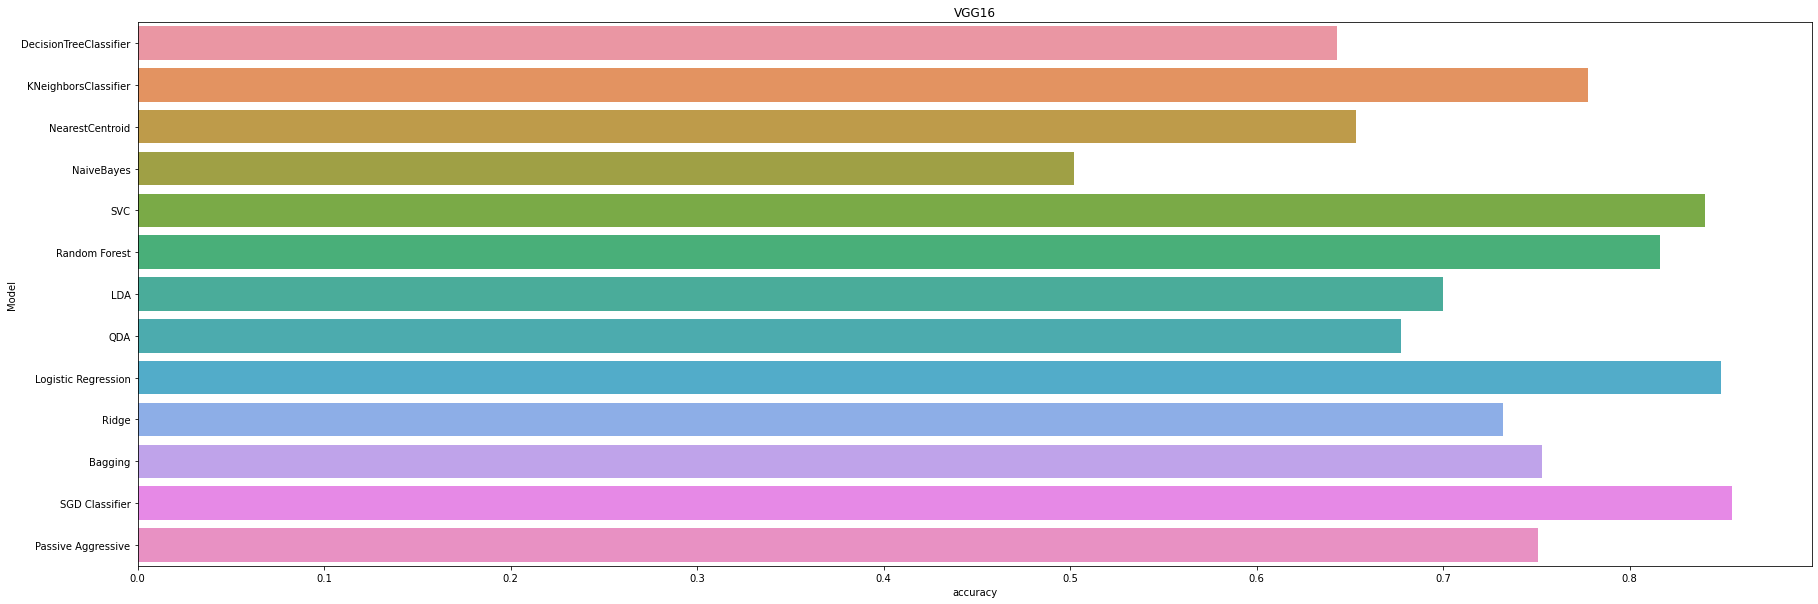

In [30]:
vgg16 = tf.keras.applications.VGG16(\
                                  include_top=False,\
                                  weights='imagenet',\
                                  input_shape=trainX[0].shape)
vg16_names, vgg16_acc = feature_extraction_test("VGG16", vgg16, trainX, trainY, valX, valY)


80142336/80134624 [==============================] - 1s 0us/step
Training model DecisionTreeClassifier
Accuracy = 0.611, 				Time taken = 4.74s
Training model KNeighborsClassifier
Accuracy = 0.741, 				Time taken = 14.21s
Training model NearestCentroid
Accuracy = 0.617, 				Time taken = 4.09s
Training model NaiveBayes
Accuracy = 0.470, 				Time taken = 0.83s
Training model SVC
Accuracy = 0.804, 				Time taken = 67.36s
Training model Random Forest
Accuracy = 0.774, 				Time taken = 25.07s
Training model LDA
Accuracy = 0.659, 				Time taken = 2.60s
Training model QDA
Accuracy = 0.633, 				Time taken = 2.59s
Training model Logistic Regression
Accuracy = 0.816, 				Time taken = 31.07s
Training model Ridge
Accuracy = 0.689, 				Time taken = 3.05s
Training model Bagging
Accuracy = 0.720, 				Time taken = 19.67s
Training model SGD Classifier
Accuracy = 0.818, 				Time taken = 198.01s
Training model Passive Aggressive
Accuracy = 0.689, 				Time taken = 3.40s


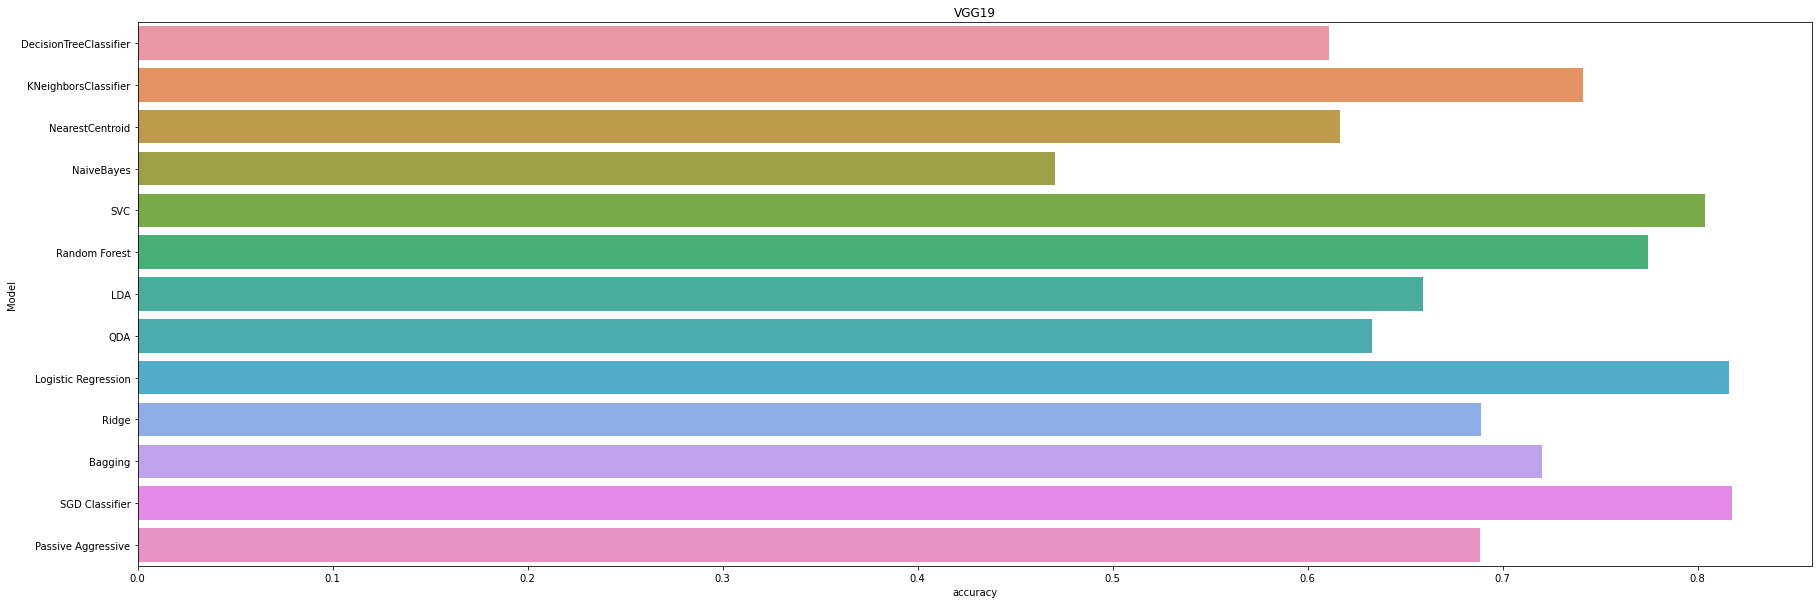

In [31]:
gc.collect()
vgg19 = tf.keras.applications.VGG19(\
                                    include_top=False,\
                                    weights='imagenet',\
                                    input_shape=trainX[0].shape)
vgg19_names, vgg19_acc = feature_extraction_test("VGG19",\
                                                 vgg19,\
                                                 trainX,\
                                                 trainY,\
                                                 valX,\
                                                 valY)

94674944/94668760 [==============================] - 1s 0us/step
Training model DecisionTreeClassifier
Accuracy = 0.563, 				Time taken = 11.10s
Training model KNeighborsClassifier
Accuracy = 0.700, 				Time taken = 26.96s
Training model NearestCentroid
Accuracy = 0.639, 				Time taken = 12.98s
Training model NaiveBayes
Accuracy = 0.510, 				Time taken = 2.95s
Training model SVC
Accuracy = 0.801, 				Time taken = 88.37s
Training model Random Forest
Accuracy = 0.759, 				Time taken = 37.10s
Training model LDA
Accuracy = 0.625, 				Time taken = 7.54s
Training model QDA
Accuracy = 0.554, 				Time taken = 7.51s
Training model Logistic Regression
Accuracy = 0.814, 				Time taken = 161.35s
Training model Ridge
Accuracy = 0.704, 				Time taken = 10.10s
Training model Bagging
Accuracy = 0.665, 				Time taken = 28.41s
Training model SGD Classifier
Accuracy = 0.820, 				Time taken = 274.94s
Training model Passive Aggressive
Accuracy = 0.677, 				Time taken = 9.89s


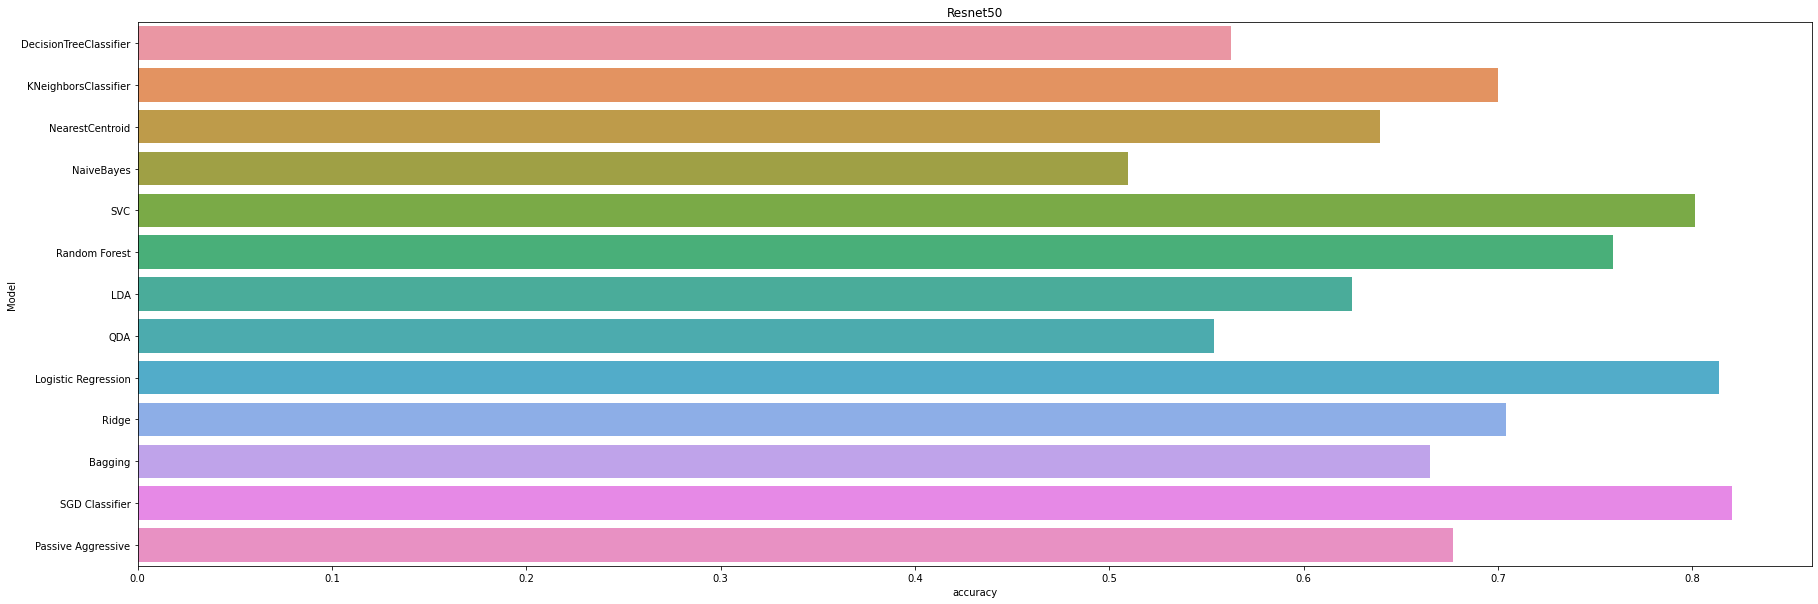

In [32]:
gc.collect()
resnet50 = tf.keras.applications.ResNet50V2(\
                                          include_top=False,\
                                          weights='imagenet',\
                                          input_shape=trainX[0].shape)
                               
resnet50_names, resnet50_acc = feature_extraction_test(\
                                                       "Resnet50",\
                                                       resnet50,\
                                                       trainX,\
                                                       trainY,\
                                                       valX,\
                                                       valY)

74842112/74836368 [==============================] - 1s 0us/step
Training model DecisionTreeClassifier
Accuracy = 0.690, 				Time taken = 10.22s
Training model KNeighborsClassifier
Accuracy = 0.854, 				Time taken = 22.63s
Training model NearestCentroid
Accuracy = 0.734, 				Time taken = 11.86s
Training model NaiveBayes
Accuracy = 0.710, 				Time taken = 3.19s
Training model SVC
Accuracy = 0.922, 				Time taken = 61.77s
Training model Random Forest
Accuracy = 0.837, 				Time taken = 91.07s
Training model LDA
Accuracy = 0.792, 				Time taken = 6.94s
Training model QDA
Accuracy = 0.798, 				Time taken = 6.70s
Training model Logistic Regression
Accuracy = 0.927, 				Time taken = 126.36s
Training model Ridge
Accuracy = 0.855, 				Time taken = 8.89s
Training model Bagging
Accuracy = 0.784, 				Time taken = 29.73s
Training model SGD Classifier
Accuracy = 0.917, 				Time taken = 93.86s
Training model Passive Aggressive
Accuracy = 0.819, 				Time taken = 8.88s


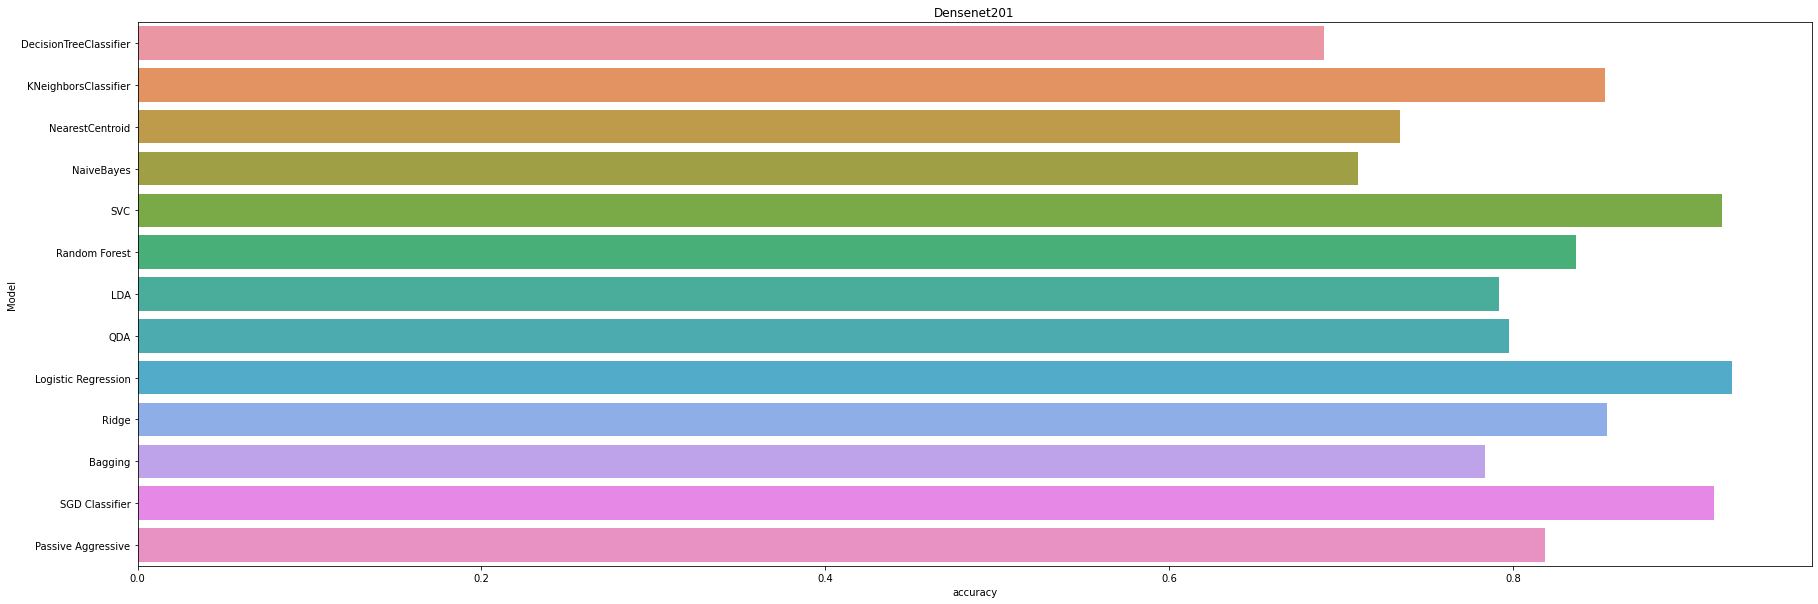

In [33]:
gc.collect()
densenet = tf.keras.applications.DenseNet201(\
                                  include_top=False,\
                                  input_shape=trainX[0].shape)
densenet_names, densenet_acc = feature_extraction_test(\
                                                       "Densenet201",\
                                                       densenet,\
                                                       trainX,\
                                                       trainY,\
                                                       valX,\
                                                       valY)

  Pretrained Model  DecisionTreeClassifier  KNeighborsClassifier  \
0            VGG16                0.643125              0.777500   
1            VGG19                0.611042              0.741042   
2         ResNet50                0.562708              0.700208   
3         DenseNet                0.690208              0.853542   

   NearestCentroid  NaiveBayes       SVC  Random Forest       LDA       QDA  \
0         0.653333    0.502292  0.840208       0.816250  0.699792  0.677500   
1         0.616667    0.470417  0.803750       0.774375  0.659375  0.633125   
2         0.639375    0.509583  0.801250       0.759375  0.625000  0.554167   
3         0.734375    0.710000  0.921667       0.836875  0.791875  0.797917   

   Logistic Regression     Ridge   Bagging  SGD Classifier  Passive Aggressive  
0             0.848958  0.732083  0.753125        0.854792            0.750625  
1             0.816250  0.688750  0.720208        0.817500            0.688542  
2             0.8135

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3720: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


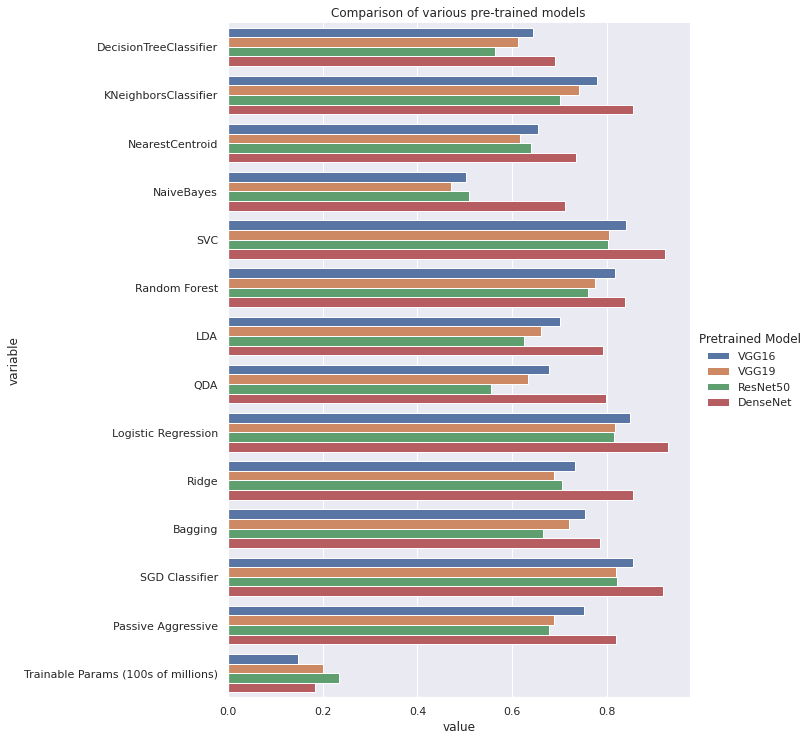

In [34]:
gc.collect()
def compare_pretrained_models():
    def pretty_print(x):
        dfs = pd.DataFrame(x)
        pd.set_option('display.max_columns', None)
        print(dfs)
    classifier_names = densenet_names
    models = [vgg16, vgg19, resnet50, densenet]
    accuracies = [vgg16_acc, vgg19_acc, resnet50_acc, densenet_acc]
    pretrained=['VGG16', 'VGG19', 'ResNet50', 'DenseNet']
    data = {}
    data["Pretrained Model"] = pretrained
    for i, name in enumerate(classifier_names):
        arr = []
        for acc_arr in accuracies:
            arr.append(acc_arr[i])
        data[name] = arr
    pretty_print(data)

    parameters = [m.count_params() / (100_000_000) for m in models]
    data["Trainable Params (100s of millions)"] = parameters
    dfs = pd.DataFrame(data)
    dfs1 = pd.melt(dfs, id_vars="Pretrained Model")
    print(dfs1)
    sns.set(rc={'figure.figsize':(20, 15,)})
    p = sns.factorplot(hue="Pretrained Model", x='value', y='variable', data=dfs1, kind='bar', size=10, orient='h')
    plt.title('Comparison of various pre-trained models')
    plt.show()


compare_pretrained_models()

In [45]:
def print_all_saved_accuracies():
    classifier_names = densenet_names
    models = [vgg16, vgg19, resnet50, densenet]
    accuracies = [vgg16_acc, vgg19_acc, resnet50_acc, densenet_acc]
    pretrained=['VGG16', 'VGG19', 'ResNet50', 'DenseNet']
    
    print()
    for n, a in zip(pretrained, accuracies):
        print(n, ":", len(a), a)
    print("Classifier names", ":", len(classifier_names), classifier_names)
    print("Trainable Params", ":", [m.count_params() / 100_000_000 for m in models])
print_all_saved_accuracies()


VGG16 : 13 [0.643125, 0.7775, 0.6533333333333333, 0.5022916666666667, 0.8402083333333333, 0.81625, 0.6997916666666667, 0.6775, 0.8489583333333334, 0.7320833333333333, 0.753125, 0.8547916666666666, 0.750625]
VGG19 : 13 [0.6110416666666667, 0.7410416666666667, 0.6166666666666667, 0.47041666666666665, 0.80375, 0.774375, 0.659375, 0.633125, 0.81625, 0.68875, 0.7202083333333333, 0.8175, 0.6885416666666667]
ResNet50 : 13 [0.5627083333333334, 0.7002083333333333, 0.639375, 0.5095833333333334, 0.80125, 0.759375, 0.625, 0.5541666666666667, 0.8135416666666667, 0.7041666666666667, 0.6652083333333333, 0.8204166666666667, 0.6770833333333334]
DenseNet : 13 [0.6902083333333333, 0.8535416666666666, 0.734375, 0.71, 0.9216666666666666, 0.836875, 0.791875, 0.7979166666666667, 0.9272916666666666, 0.8545833333333334, 0.7839583333333333, 0.916875, 0.81875]
Classifier names : 13 ['DecisionTreeClassifier', 'KNeighborsClassifier', 'NearestCentroid', 'NaiveBayes', 'SVC', 'Random Forest', 'LDA', 'QDA', 'Logistic

# Fine Tune

In [35]:
def combine_and_train_finetune(\
                               model1,\
                               model2,\
                               trainX,\
                               trainY,\
                               valX,\
                               valY,\
                               nepochs,
                               layer_to_unfreeze):
    combined = tf.keras.Sequential(name=f"{model1.name}-finetuned")
    model1.trainable = False
    combined.add(model1)
    combined.add(model2)

    logging.info("Phase 1 starting...")
    opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
    combined.compile(optimizer=opt,\
                     loss='sparse_categorical_crossentropy',\
                     metrics=['accuracy'])
    plot = Plot()
    history = combined.fit(trainX, trainY, \
                    validation_data=(valX, valY),\
                    batch_size=32,\
                    epochs=nepochs,\
                    callbacks=get_callbacks_decay_after(-1, combined.name))
    plot.plot_history(history, nepochs, "combined - Phase 1")
    plt.show()
    logging.info("OK.")

    logging.info("Loading weights from checkpoint...")
    combined.load_weights(get_checkpoint_filepath(combined.name))
    logging.info("OK.")

    logging.info("Phase 2 starting...")
    model1.trainable = True
    trainableFlag = False
    for layer in model1.layers:
        if layer.name == layer_to_unfreeze:
            trainableFlag = True
        layer.trainable = trainableFlag
    opt = tf.keras.optimizers.RMSprop(learning_rate=1.0e-5)
    combined.compile(optimizer=opt,\
                     loss='sparse_categorical_crossentropy',\
                     metrics=['accuracy'])
    history = combined.fit(trainX, trainY, \
                    validation_data=(valX, valY),\
                    batch_size=32,\
                    epochs=nepochs,
                    callbacks=get_callbacks_decay_after(2, combined.name))
    logging.info("OK.")

    plot.plot_history(history, nepochs, "combined - Phase 2")
    plt.show()
    plot.superplot()
    plt.show()

    return combined, history

   

In [36]:
import IPython

n_classes = len(np.unique(np.concatenate((trainY, valY))))
class ShallowNet:
    @staticmethod
    def build(inshape, nlabels):
        model = tf.keras.Sequential(name="BaseLineShallowNet")
        model.add(tf.keras.layers.Flatten())
        model.add(tf.keras.layers.Dropout(rate=0.25))
        model.add(tf.keras.layers.Dense(512))
        model.add(tf.keras.layers.Dropout(rate=0.25))
        model.add(tf.keras.layers.Dense(nlabels, activation='softmax'))
        return model

2021-04-26 13:02:49,107 - root - INFO - Phase 1 starting...
2021-04-26 13:02:49,107 - root - INFO - Phase 1 starting...
Epoch 1/25
600/600 [==============================] - 12s 20ms/step - loss: 1.3988 - accuracy: 0.6331 - val_loss: 0.7752 - val_accuracy: 0.7577
Epoch 2/25
600/600 [==============================] - 12s 19ms/step - loss: 0.6991 - accuracy: 0.7767 - val_loss: 0.5322 - val_accuracy: 0.8246
Epoch 3/25
600/600 [==============================] - 11s 19ms/step - loss: 0.5936 - accuracy: 0.8043 - val_loss: 0.5657 - val_accuracy: 0.8075
Epoch 4/25
600/600 [==============================] - 11s 19ms/step - loss: 0.5549 - accuracy: 0.8142 - val_loss: 0.5428 - val_accuracy: 0.8227
Epoch 5/25
600/600 [==============================] - 11s 18ms/step - loss: 0.5496 - accuracy: 0.8199 - val_loss: 0.5123 - val_accuracy: 0.8321
Epoch 6/25
600/600 [==============================] - 11s 19ms/step - loss: 0.5359 - accuracy: 0.8211 - val_loss: 0.4784 - val_accuracy: 0.8452
Epoch 7/25
600/6

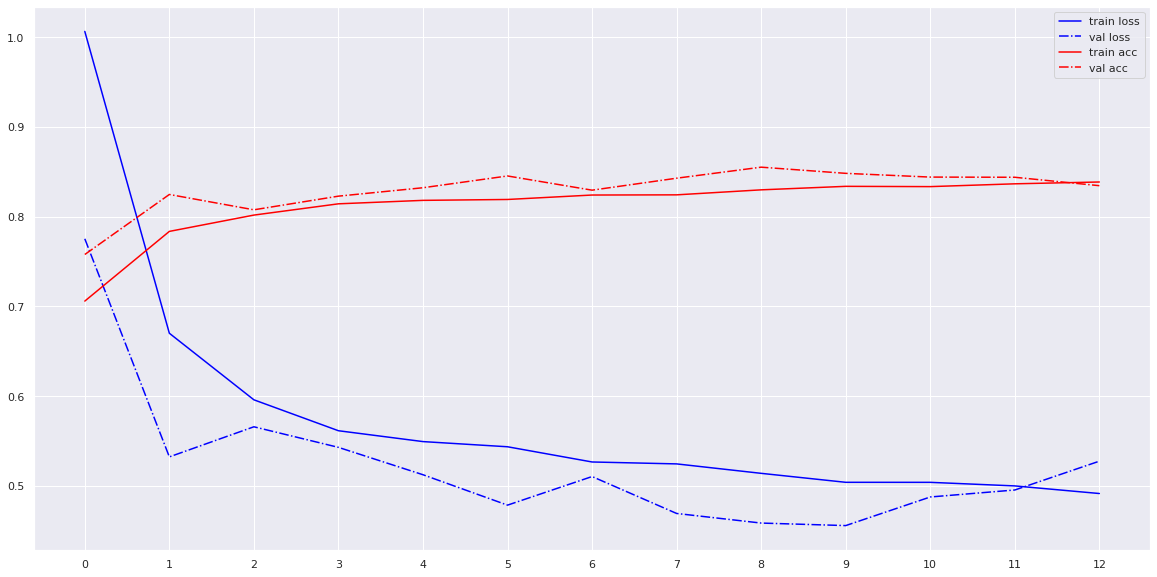

Best validation accuracy: 0.8550000190734863, epoch = 8
Best validation loss: 0.45562613010406494, epoch = 9
2021-04-26 13:05:19,335 - root - INFO - OK.
2021-04-26 13:05:19,335 - root - INFO - OK.
2021-04-26 13:05:19,346 - root - INFO - Loading weights from checkpoint...
2021-04-26 13:05:19,346 - root - INFO - Loading weights from checkpoint...
2021-04-26 13:05:19,510 - root - INFO - OK.
2021-04-26 13:05:19,510 - root - INFO - OK.
2021-04-26 13:05:19,513 - root - INFO - Phase 2 starting...
2021-04-26 13:05:19,513 - root - INFO - Phase 2 starting...
Epoch 1/25
600/600 [==============================] - 23s 36ms/step - loss: 0.4145 - accuracy: 0.8617 - val_loss: 0.4039 - val_accuracy: 0.8746
Epoch 2/25
600/600 [==============================] - 22s 36ms/step - loss: 0.2515 - accuracy: 0.9158 - val_loss: 0.3001 - val_accuracy: 0.9046
Epoch 3/25
Learning Rate: 9.999999747378752e-06 --> 3.6787946555705275e-06
600/600 [==============================] - 22s 36ms/step - loss: 0.1481 - accuracy

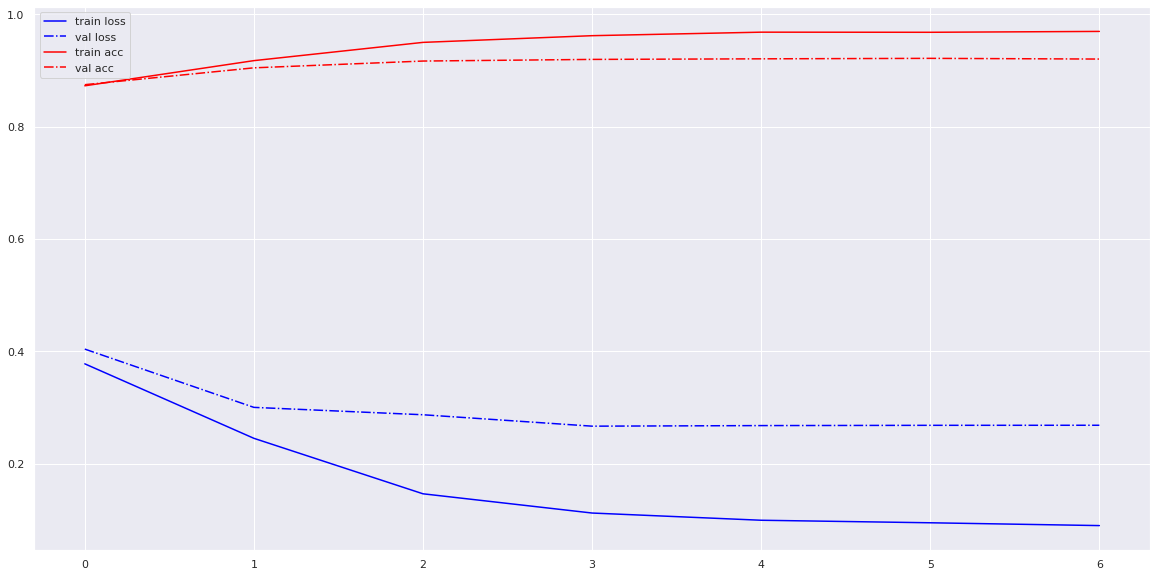

Best validation accuracy: 0.9214583039283752, epoch = 5
Best validation loss: 0.2666623592376709, epoch = 3


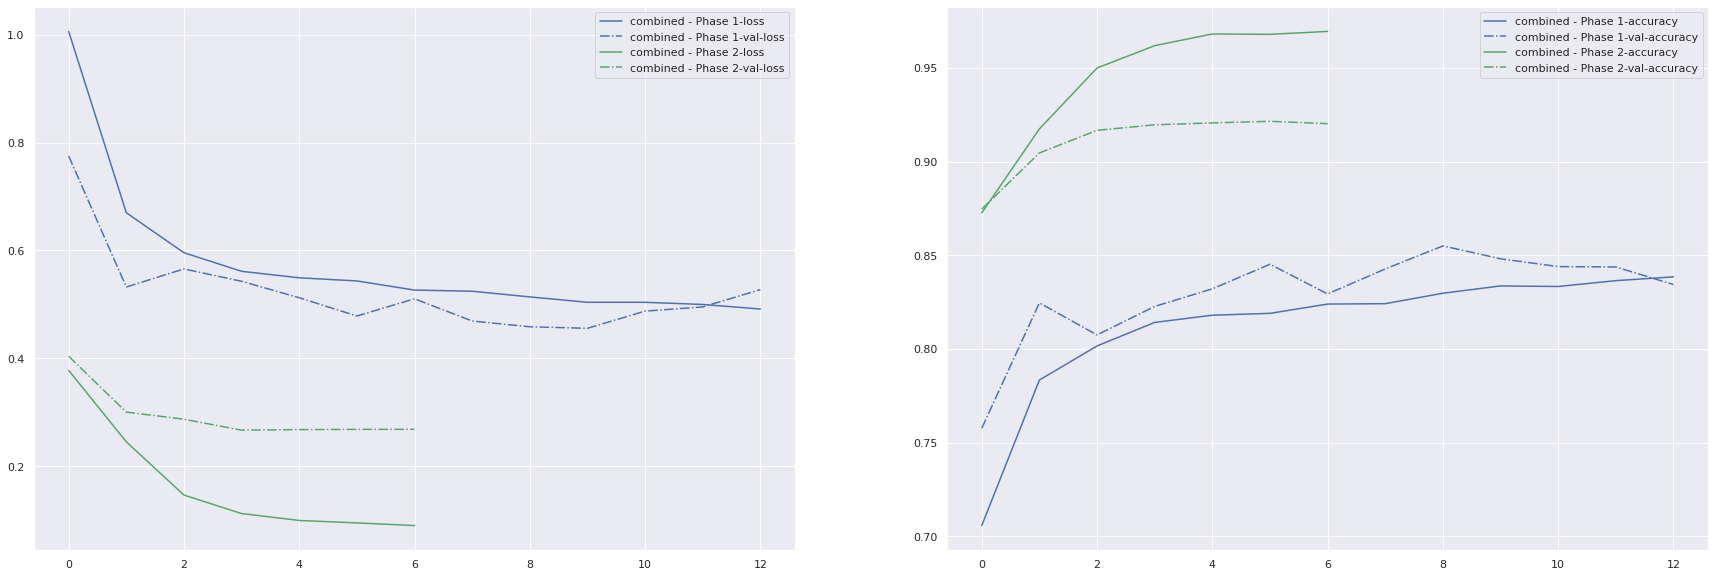

In [46]:
vgg16_ft = tf.keras.applications.VGG16(\
                                  include_top=False,\
                                  weights='imagenet',\
                                  input_shape=trainX[0].shape)
vgg16_ft.trainable = False

myModel = ShallowNet.build(vgg16_ft.output_shape, n_classes)

vgg16_combined_model, vgg16_combined_history = combine_and_train_finetune(vgg16_ft, myModel, trainX, trainY, valX, valY, 25, 'block4_conv2')
vgg16_acc.append(max(vgg16_combined_history.history['val_accuracy']))


In [47]:
def print_all_saved_accuracies():
    classifier_names = densenet_names
    models = [vgg16, vgg19, resnet50, densenet]
    accuracies = [vgg16_acc, vgg19_acc, resnet50_acc, densenet_acc]
    pretrained=['VGG16', 'VGG19', 'ResNet50', 'DenseNet']
    
    print()
    for n, a in zip(pretrained, accuracies):
        print(n, ":", len(a), a)
    print("Classifier names", ":", len(classifier_names), classifier_names)
    print("Trainable Params", ":", [m.count_params() / 100_000_000 for m in models])
print_all_saved_accuracies()


VGG16 : 14 [0.643125, 0.7775, 0.6533333333333333, 0.5022916666666667, 0.8402083333333333, 0.81625, 0.6997916666666667, 0.6775, 0.8489583333333334, 0.7320833333333333, 0.753125, 0.8547916666666666, 0.750625, 0.9214583039283752]
VGG19 : 13 [0.6110416666666667, 0.7410416666666667, 0.6166666666666667, 0.47041666666666665, 0.80375, 0.774375, 0.659375, 0.633125, 0.81625, 0.68875, 0.7202083333333333, 0.8175, 0.6885416666666667]
ResNet50 : 13 [0.5627083333333334, 0.7002083333333333, 0.639375, 0.5095833333333334, 0.80125, 0.759375, 0.625, 0.5541666666666667, 0.8135416666666667, 0.7041666666666667, 0.6652083333333333, 0.8204166666666667, 0.6770833333333334]
DenseNet : 13 [0.6902083333333333, 0.8535416666666666, 0.734375, 0.71, 0.9216666666666666, 0.836875, 0.791875, 0.7979166666666667, 0.9272916666666666, 0.8545833333333334, 0.7839583333333333, 0.916875, 0.81875]
Classifier names : 13 ['DecisionTreeClassifier', 'KNeighborsClassifier', 'NearestCentroid', 'NaiveBayes', 'SVC', 'Random Forest', 'LD

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

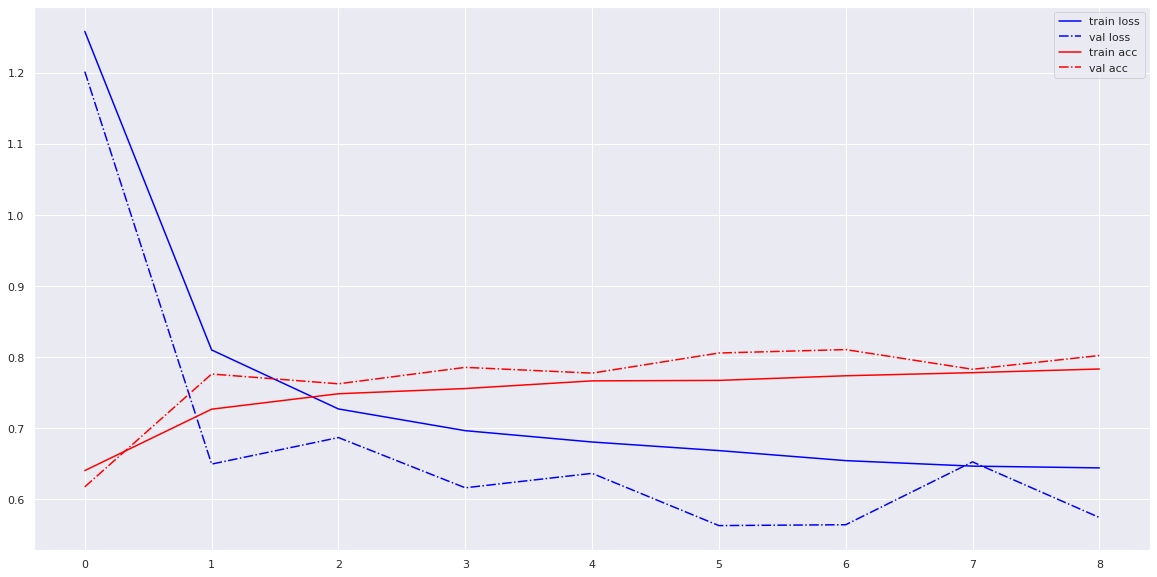

Best validation accuracy: 0.8106250166893005, epoch = 6
Best validation loss: 0.5629602670669556, epoch = 5
2021-04-26 13:10:09,484 - root - INFO - OK.
2021-04-26 13:10:09,484 - root - INFO - OK.
2021-04-26 13:10:09,486 - root - INFO - Loading weights from checkpoint...
2021-04-26 13:10:09,486 - root - INFO - Loading weights from checkpoint...
2021-04-26 13:10:09,689 - root - INFO - OK.
2021-04-26 13:10:09,689 - root - INFO - OK.
2021-04-26 13:10:09,697 - root - INFO - Phase 2 starting...
2021-04-26 13:10:09,697 - root - INFO - Phase 2 starting...
Epoch 1/25
600/600 [==============================] - 22s 36ms/step - loss: 0.5099 - accuracy: 0.8237 - val_loss: 0.4547 - val_accuracy: 0.8510
Epoch 2/25
600/600 [==============================] - 21s 35ms/step - loss: 0.3479 - accuracy: 0.8812 - val_loss: 0.4148 - val_accuracy: 0.8587
Epoch 3/25
Learning Rate: 9.999999747378752e-06 --> 3.6787946555705275e-06
600/600 [==============================] - 21s 35ms/step - loss: 0.2454 - accuracy:

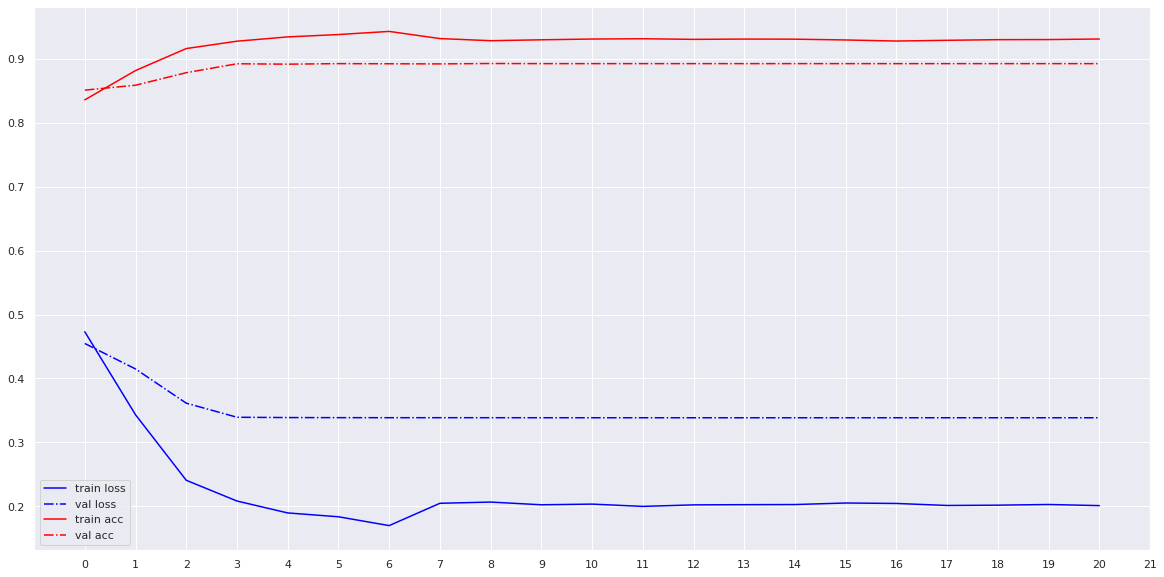

Best validation accuracy: 0.8927083611488342, epoch = 8
Best validation loss: 0.3384968936443329, epoch = 17


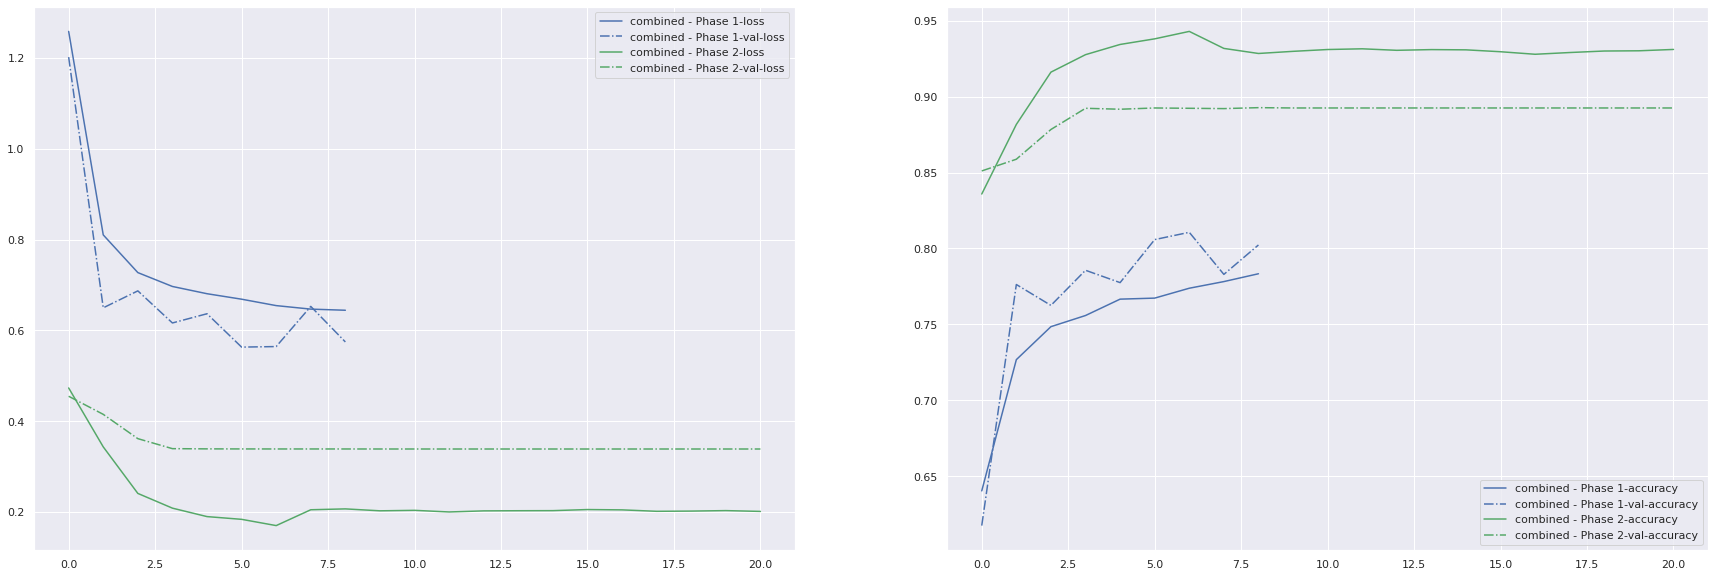


VGG16 : 14 [0.643125, 0.7775, 0.6533333333333333, 0.5022916666666667, 0.8402083333333333, 0.81625, 0.6997916666666667, 0.6775, 0.8489583333333334, 0.7320833333333333, 0.753125, 0.8547916666666666, 0.750625, 0.9214583039283752]
VGG19 : 14 [0.6110416666666667, 0.7410416666666667, 0.6166666666666667, 0.47041666666666665, 0.80375, 0.774375, 0.659375, 0.633125, 0.81625, 0.68875, 0.7202083333333333, 0.8175, 0.6885416666666667, 0.8927083611488342]
ResNet50 : 13 [0.5627083333333334, 0.7002083333333333, 0.639375, 0.5095833333333334, 0.80125, 0.759375, 0.625, 0.5541666666666667, 0.8135416666666667, 0.7041666666666667, 0.6652083333333333, 0.8204166666666667, 0.6770833333333334]
DenseNet : 13 [0.6902083333333333, 0.8535416666666666, 0.734375, 0.71, 0.9216666666666666, 0.836875, 0.791875, 0.7979166666666667, 0.9272916666666666, 0.8545833333333334, 0.7839583333333333, 0.916875, 0.81875]
Classifier names : 13 ['DecisionTreeClassifier', 'KNeighborsClassifier', 'NearestCentroid', 'NaiveBayes', 'SVC', 

In [48]:
gc.collect()
gc.collect()
vgg19_ft = tf.keras.applications.VGG19(\
                                    include_top=False,\
                                    weights='imagenet',\
                                    input_shape=trainX[0].shape)
vgg19_ft.trainable = False
print(vgg19_ft.summary())

myModel = ShallowNet.build(vgg19_ft.output_shape, n_classes)

vgg19_combined_model, vgg19_combined_history = combine_and_train_finetune(vgg19_ft, myModel, trainX, trainY, valX, valY, 25, 'block4_pool')
vgg19_acc.append(max(vgg19_combined_history.history['val_accuracy']))
print_all_saved_accuracies()

Model: "densenet201"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_4 (ZeroPadding2D (None, 70, 70, 3)    0           input_17[0][0]                   
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 32, 32, 64)   9408        zero_padding2d_4[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1/conv[0][0]                 
________________________________________________________________________________________

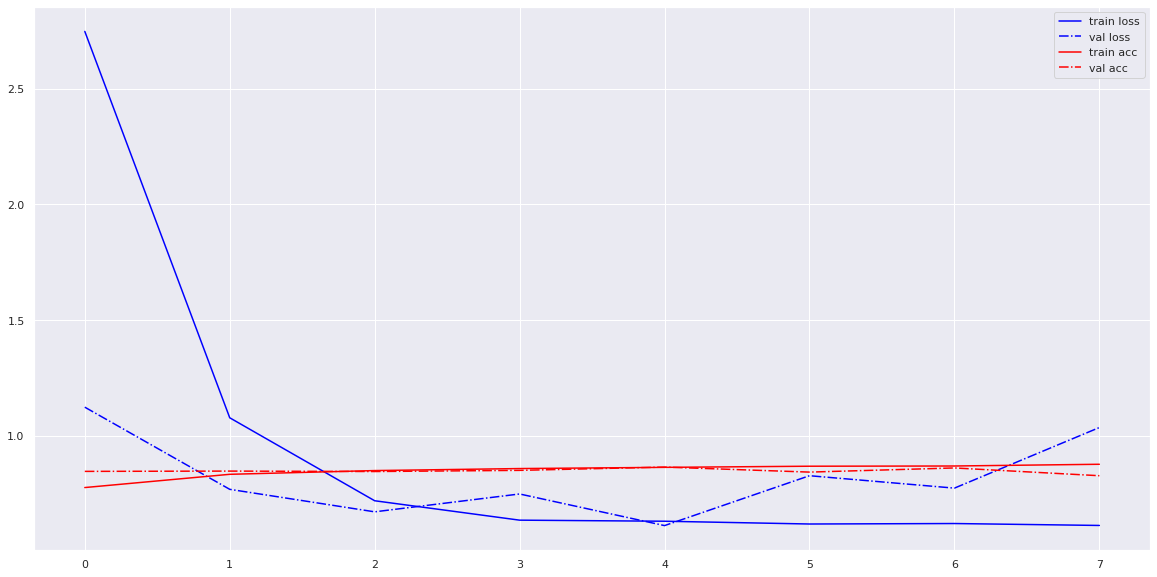

Best validation accuracy: 0.8647916913032532, epoch = 4
Best validation loss: 0.612001359462738, epoch = 4
2021-04-26 13:21:16,328 - root - INFO - OK.
2021-04-26 13:21:16,328 - root - INFO - OK.
2021-04-26 13:21:16,334 - root - INFO - Loading weights from checkpoint...
2021-04-26 13:21:16,334 - root - INFO - Loading weights from checkpoint...
2021-04-26 13:21:22,095 - root - INFO - OK.
2021-04-26 13:21:22,095 - root - INFO - OK.
2021-04-26 13:21:22,104 - root - INFO - Phase 2 starting...
2021-04-26 13:21:22,104 - root - INFO - Phase 2 starting...
Epoch 1/26
600/600 [==============================] - 35s 42ms/step - loss: 0.6172 - accuracy: 0.8649 - val_loss: 0.5647 - val_accuracy: 0.8910
Epoch 2/26
600/600 [==============================] - 23s 38ms/step - loss: 0.3962 - accuracy: 0.9010 - val_loss: 0.5203 - val_accuracy: 0.8960
Epoch 3/26
Learning Rate: 9.999999747378752e-06 --> 3.6787946555705275e-06
600/600 [==============================] - 23s 38ms/step - loss: 0.3624 - accuracy: 

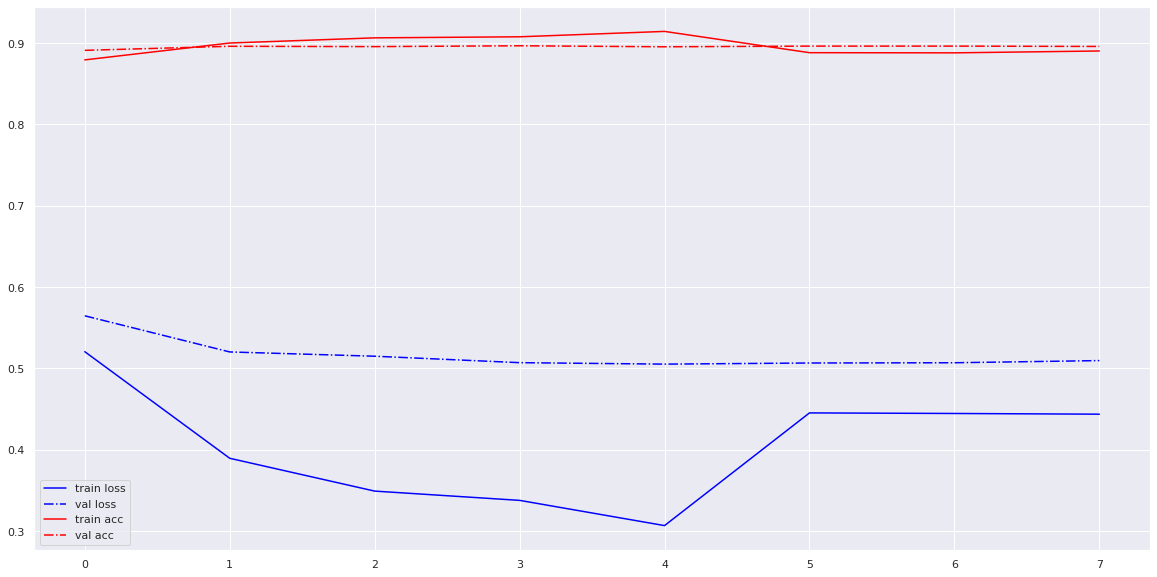

Best validation accuracy: 0.8966666460037231, epoch = 3
Best validation loss: 0.5053537487983704, epoch = 4


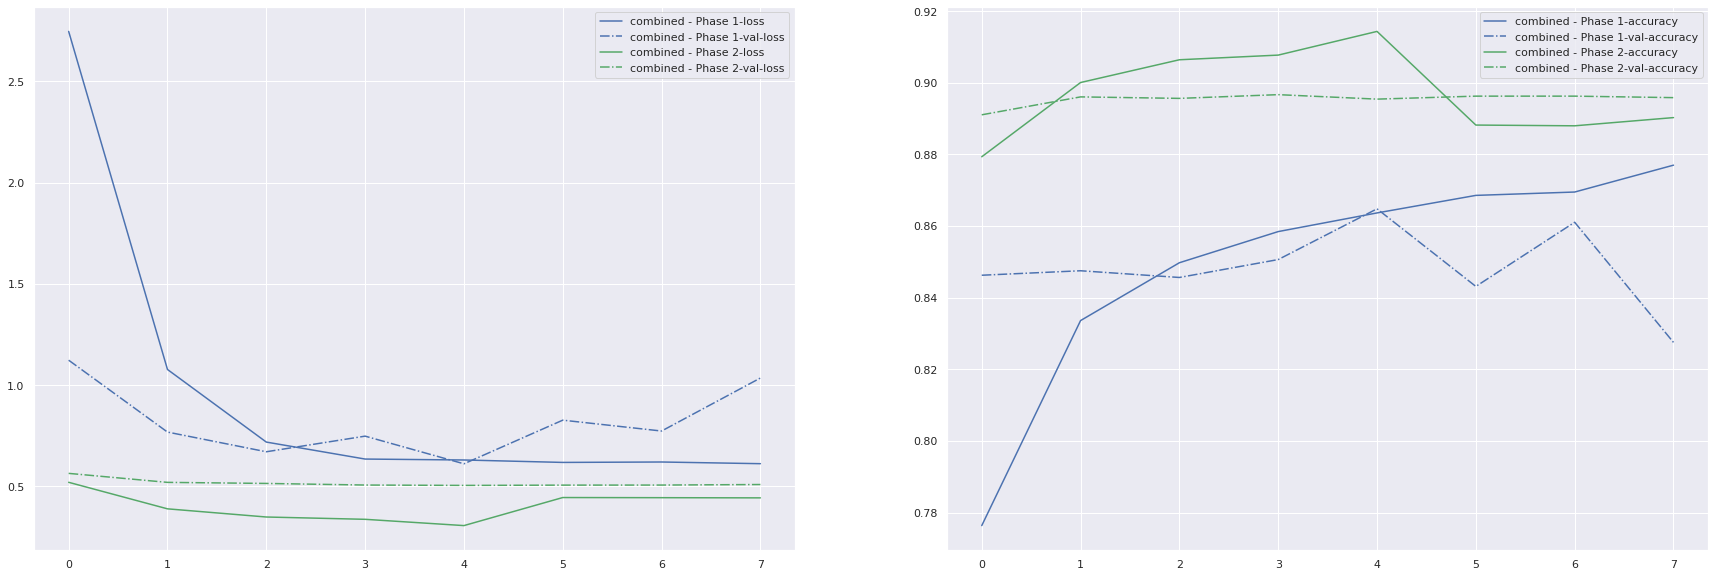


VGG16 : 14 [0.643125, 0.7775, 0.6533333333333333, 0.5022916666666667, 0.8402083333333333, 0.81625, 0.6997916666666667, 0.6775, 0.8489583333333334, 0.7320833333333333, 0.753125, 0.8547916666666666, 0.750625, 0.9214583039283752]
VGG19 : 14 [0.6110416666666667, 0.7410416666666667, 0.6166666666666667, 0.47041666666666665, 0.80375, 0.774375, 0.659375, 0.633125, 0.81625, 0.68875, 0.7202083333333333, 0.8175, 0.6885416666666667, 0.8927083611488342]
ResNet50 : 13 [0.5627083333333334, 0.7002083333333333, 0.639375, 0.5095833333333334, 0.80125, 0.759375, 0.625, 0.5541666666666667, 0.8135416666666667, 0.7041666666666667, 0.6652083333333333, 0.8204166666666667, 0.6770833333333334]
DenseNet : 14 [0.6902083333333333, 0.8535416666666666, 0.734375, 0.71, 0.9216666666666666, 0.836875, 0.791875, 0.7979166666666667, 0.9272916666666666, 0.8545833333333334, 0.7839583333333333, 0.916875, 0.81875, 0.8966666460037231]
Classifier names : 13 ['DecisionTreeClassifier', 'KNeighborsClassifier', 'NearestCentroid', '

In [49]:
gc.collect()
gc.collect()
densenet_ft = tf.keras.applications.DenseNet201(\
                                  include_top=False,\
                                  input_shape=trainX[0].shape)

densenet_ft.trainable = False
print(densenet_ft.summary())

myModel = ShallowNet.build(densenet_ft.output_shape, n_classes)

densenet_combined_model, densenet_combined_history = combine_and_train_finetune(densenet_ft, myModel, trainX, trainY, valX, valY, 26, 'conv5_block31_2_conv')
densenet_acc.append(max(densenet_combined_history.history['val_accuracy']))
print_all_saved_accuracies()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_18[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 34, 34, 64)   0           conv1_conv[0][0]                 
_________________________________________________________________________________________

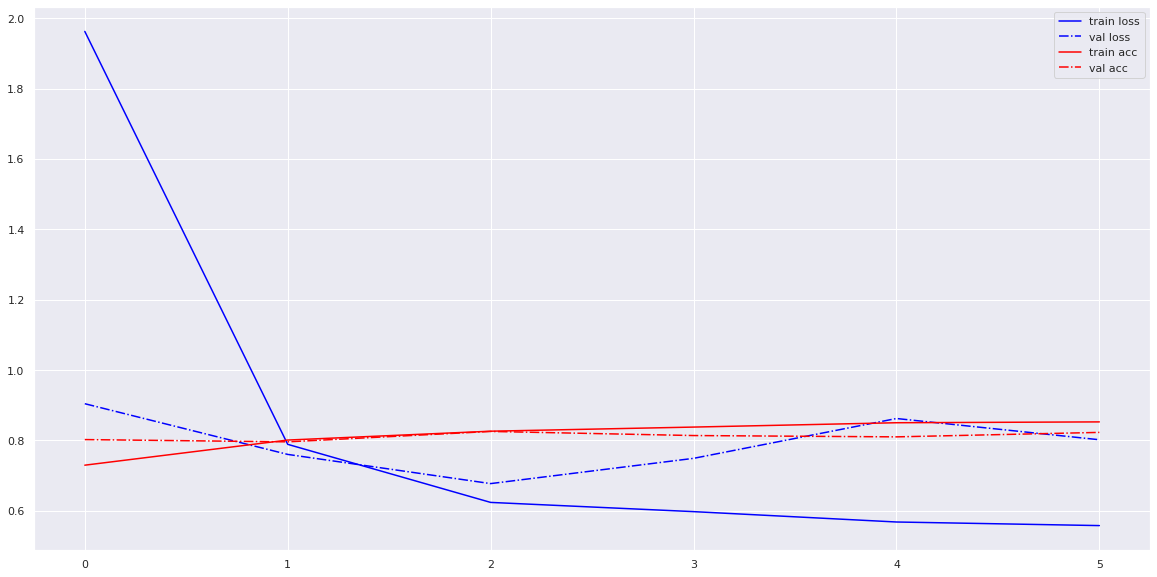

Best validation accuracy: 0.8256250023841858, epoch = 2
Best validation loss: 0.6773929595947266, epoch = 2
2021-04-26 13:27:45,485 - root - INFO - OK.
2021-04-26 13:27:45,485 - root - INFO - OK.
2021-04-26 13:27:45,487 - root - INFO - Loading weights from checkpoint...
2021-04-26 13:27:45,487 - root - INFO - Loading weights from checkpoint...
2021-04-26 13:27:46,226 - root - INFO - OK.
2021-04-26 13:27:46,226 - root - INFO - OK.
2021-04-26 13:27:46,230 - root - INFO - Phase 2 starting...
2021-04-26 13:27:46,230 - root - INFO - Phase 2 starting...
Epoch 1/26
600/600 [==============================] - 21s 30ms/step - loss: 0.9270 - accuracy: 0.8012 - val_loss: 0.9866 - val_accuracy: 0.8062
Epoch 2/26
600/600 [==============================] - 18s 29ms/step - loss: 0.5530 - accuracy: 0.8487 - val_loss: 0.8274 - val_accuracy: 0.8223
Epoch 3/26
Learning Rate: 9.999999747378752e-06 --> 3.6787946555705275e-06
600/600 [==============================] - 18s 29ms/step - loss: 0.4010 - accuracy:

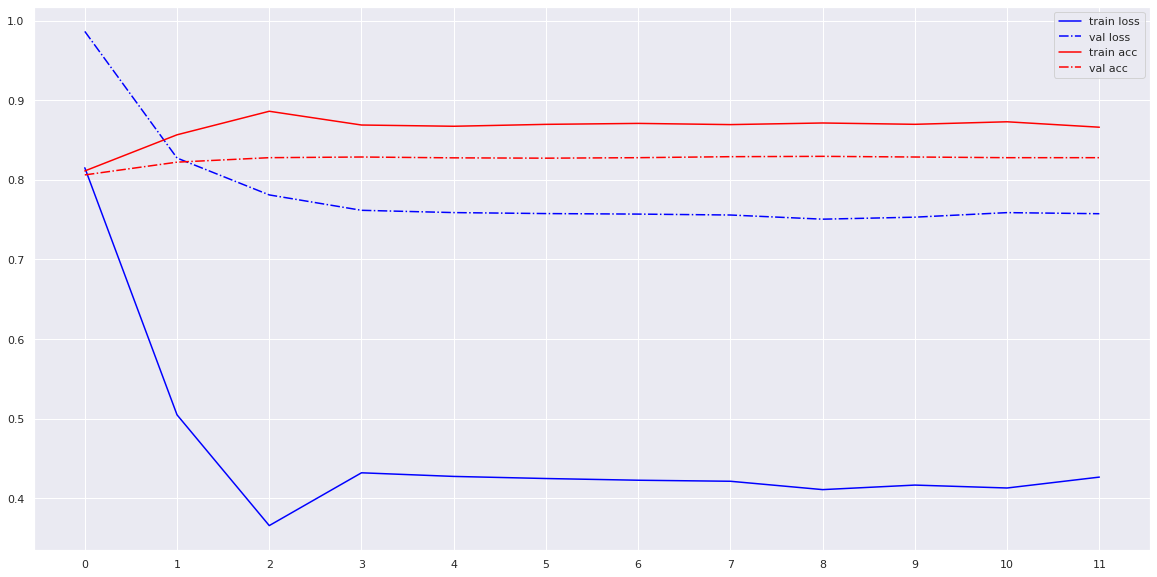

Best validation accuracy: 0.8295833468437195, epoch = 8
Best validation loss: 0.7506252527236938, epoch = 8


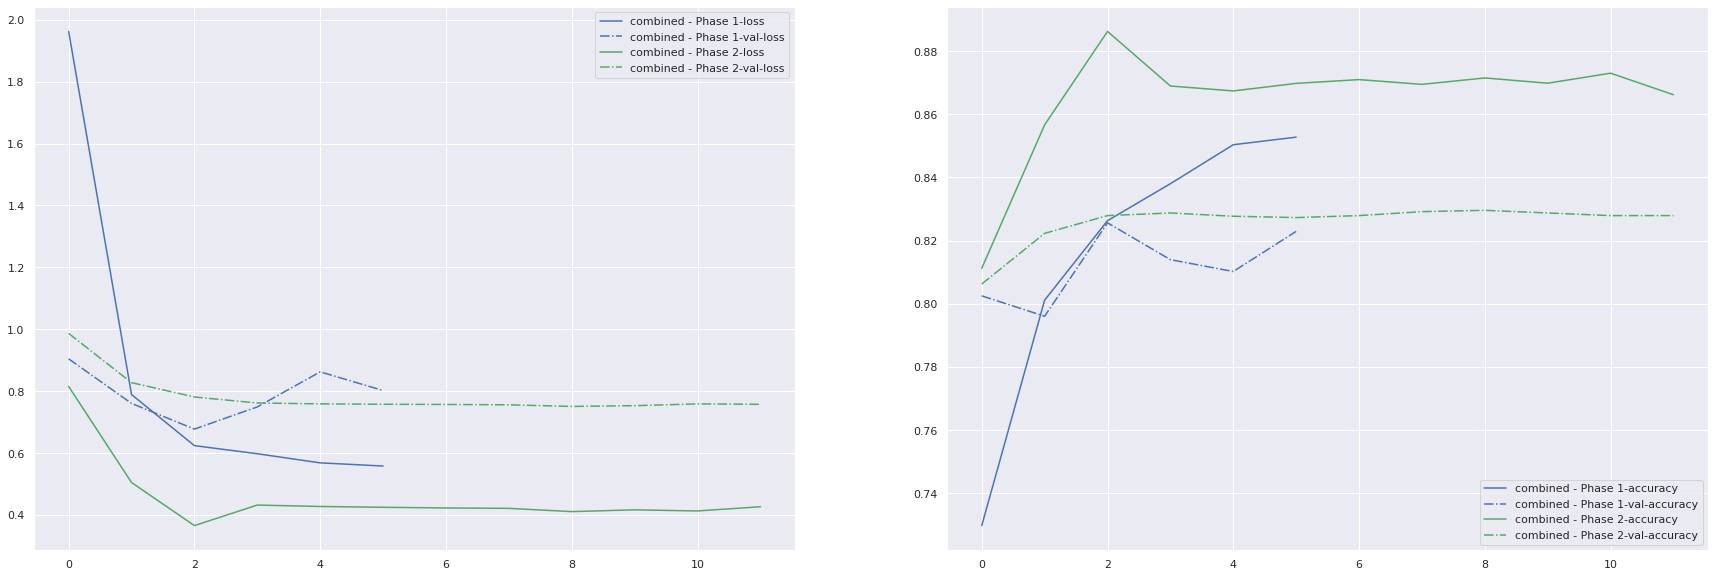


VGG16 : 14 [0.643125, 0.7775, 0.6533333333333333, 0.5022916666666667, 0.8402083333333333, 0.81625, 0.6997916666666667, 0.6775, 0.8489583333333334, 0.7320833333333333, 0.753125, 0.8547916666666666, 0.750625, 0.9214583039283752]
VGG19 : 14 [0.6110416666666667, 0.7410416666666667, 0.6166666666666667, 0.47041666666666665, 0.80375, 0.774375, 0.659375, 0.633125, 0.81625, 0.68875, 0.7202083333333333, 0.8175, 0.6885416666666667, 0.8927083611488342]
ResNet50 : 14 [0.5627083333333334, 0.7002083333333333, 0.639375, 0.5095833333333334, 0.80125, 0.759375, 0.625, 0.5541666666666667, 0.8135416666666667, 0.7041666666666667, 0.6652083333333333, 0.8204166666666667, 0.6770833333333334, 0.8295833468437195]
DenseNet : 14 [0.6902083333333333, 0.8535416666666666, 0.734375, 0.71, 0.9216666666666666, 0.836875, 0.791875, 0.7979166666666667, 0.9272916666666666, 0.8545833333333334, 0.7839583333333333, 0.916875, 0.81875, 0.8966666460037231]
Classifier names : 13 ['DecisionTreeClassifier', 'KNeighborsClassifier', 

In [53]:
gc.collect()
gc.collect()

resnet50_ft = tf.keras.applications.ResNet50V2(\
                                          include_top=False,\
                                          weights='imagenet',\
                                          input_shape=trainX[0].shape)

resnet50_ft.trainable = False
print(resnet50_ft.summary())

myModel = ShallowNet.build(resnet50_ft.output_shape, n_classes)

resnet50_combined_model, resnet50_combined_history = combine_and_train_finetune(resnet50_ft, myModel, trainX, trainY, valX, valY, 26, 'conv5_block3_1_conv')
resnet50_acc.append(max(resnet50_combined_history.history['val_accuracy']))
print_all_saved_accuracies()

  Pretrained Model  DecisionTreeClassifier  KNeighborsClassifier  \
0            VGG16                0.643125              0.777500   
1            VGG19                0.611042              0.741042   
2         ResNet50                0.562708              0.700208   
3         DenseNet                0.690208              0.853542   

   NearestCentroid  NaiveBayes       SVC  Random Forest       LDA       QDA  \
0         0.653333    0.502292  0.840208       0.816250  0.699792  0.677500   
1         0.616667    0.470417  0.803750       0.774375  0.659375  0.633125   
2         0.639375    0.509583  0.801250       0.759375  0.625000  0.554167   
3         0.734375    0.710000  0.921667       0.836875  0.791875  0.797917   

   Logistic Regression     Ridge   Bagging  SGD Classifier  \
0             0.848958  0.732083  0.753125        0.854792   
1             0.816250  0.688750  0.720208        0.817500   
2             0.813542  0.704167  0.665208        0.820417   
3             0

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3720: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


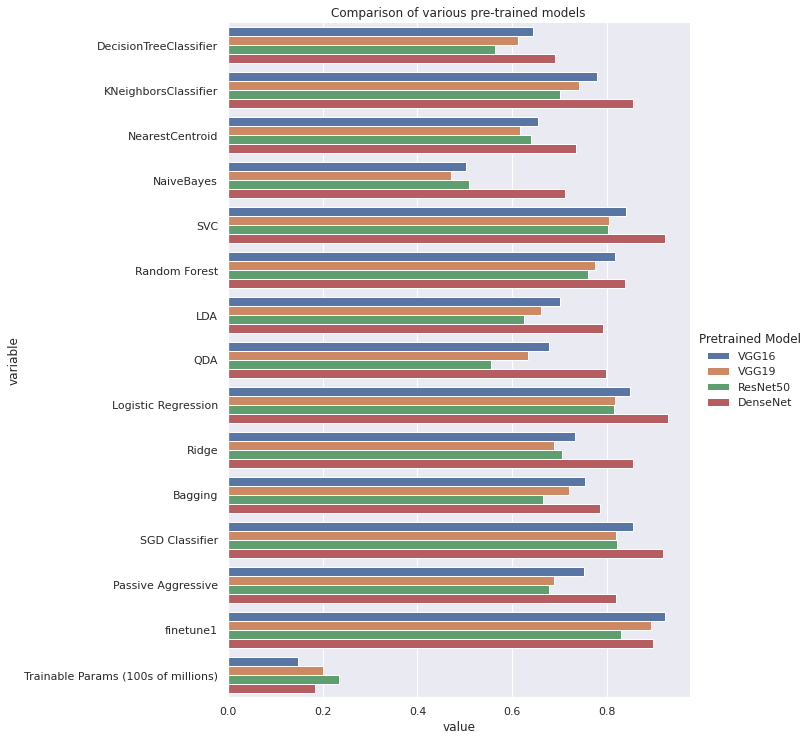

In [54]:
densenet_names.append('finetune1')
compare_pretrained_models()

In [55]:
import IPython

n_classes = len(np.unique(np.concatenate((trainY, valY))))
class ThreeAdditionalLayers:
    @staticmethod
    def build(inshape, nlabels):
        model = tf.keras.Sequential(name="BaseLineShallowNet")
        model.add(tf.keras.layers.Flatten())
        model.add(tf.keras.layers.Dropout(rate=0.25))
        model.add(tf.keras.layers.Dense(1024))
        model.add(tf.keras.layers.Dropout(rate=0.25))
        model.add(tf.keras.layers.Dense(512))
        model.add(tf.keras.layers.Dropout(rate=0.25))
        model.add(tf.keras.layers.Dense(nlabels, activation='softmax'))
        return model

2021-04-26 13:32:22,007 - root - INFO - Phase 1 starting...
2021-04-26 13:32:22,007 - root - INFO - Phase 1 starting...
Epoch 1/25
600/600 [==============================] - 13s 20ms/step - loss: 2.6510 - accuracy: 0.5660 - val_loss: 0.8859 - val_accuracy: 0.7425
Epoch 2/25
600/600 [==============================] - 12s 20ms/step - loss: 0.9173 - accuracy: 0.7235 - val_loss: 0.7410 - val_accuracy: 0.7646
Epoch 3/25
600/600 [==============================] - 12s 20ms/step - loss: 0.7366 - accuracy: 0.7597 - val_loss: 0.6750 - val_accuracy: 0.7792
Epoch 4/25
600/600 [==============================] - 12s 20ms/step - loss: 0.6834 - accuracy: 0.7796 - val_loss: 0.6378 - val_accuracy: 0.7965
Epoch 5/25
600/600 [==============================] - 12s 20ms/step - loss: 0.6782 - accuracy: 0.7867 - val_loss: 0.5894 - val_accuracy: 0.8083
Epoch 6/25
600/600 [==============================] - 12s 20ms/step - loss: 0.6585 - accuracy: 0.7901 - val_loss: 0.5844 - val_accuracy: 0.8108
Epoch 7/25
600/6

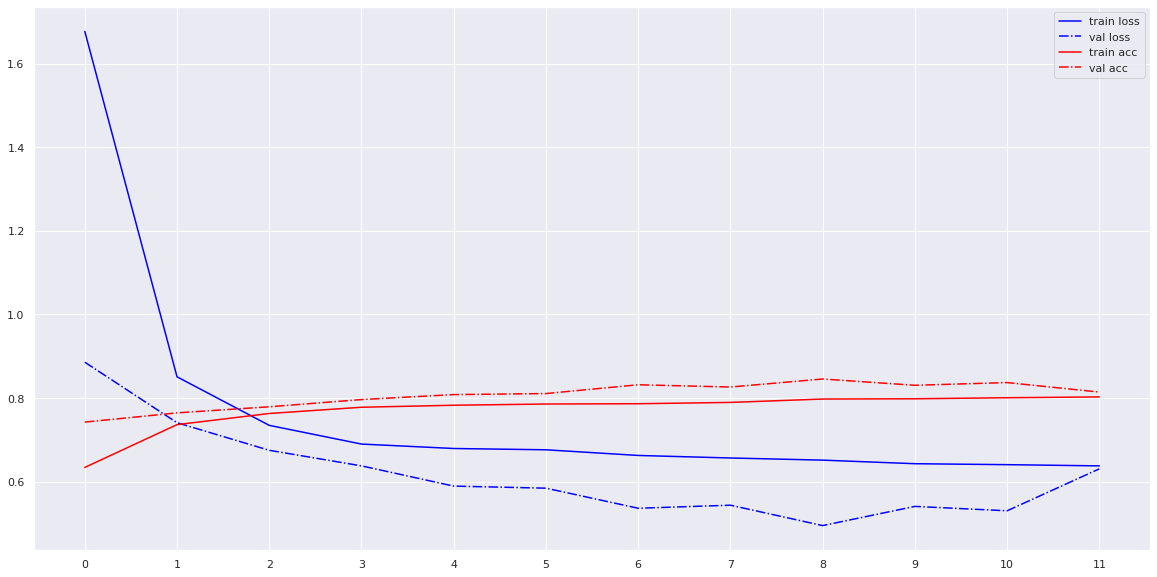

Best validation accuracy: 0.8456249833106995, epoch = 8
Best validation loss: 0.4948834180831909, epoch = 8
2021-04-26 13:34:49,193 - root - INFO - OK.
2021-04-26 13:34:49,193 - root - INFO - OK.
2021-04-26 13:34:49,201 - root - INFO - Loading weights from checkpoint...
2021-04-26 13:34:49,201 - root - INFO - Loading weights from checkpoint...
2021-04-26 13:34:49,389 - root - INFO - OK.
2021-04-26 13:34:49,389 - root - INFO - OK.
2021-04-26 13:34:49,392 - root - INFO - Phase 2 starting...
2021-04-26 13:34:49,392 - root - INFO - Phase 2 starting...
Epoch 1/25
600/600 [==============================] - 23s 37ms/step - loss: 0.4529 - accuracy: 0.8557 - val_loss: 0.4226 - val_accuracy: 0.8717
Epoch 2/25
600/600 [==============================] - 22s 37ms/step - loss: 0.2705 - accuracy: 0.9099 - val_loss: 0.3028 - val_accuracy: 0.9060
Epoch 3/25
Learning Rate: 9.999999747378752e-06 --> 3.6787946555705275e-06
600/600 [==============================] - 22s 37ms/step - loss: 0.1617 - accuracy:

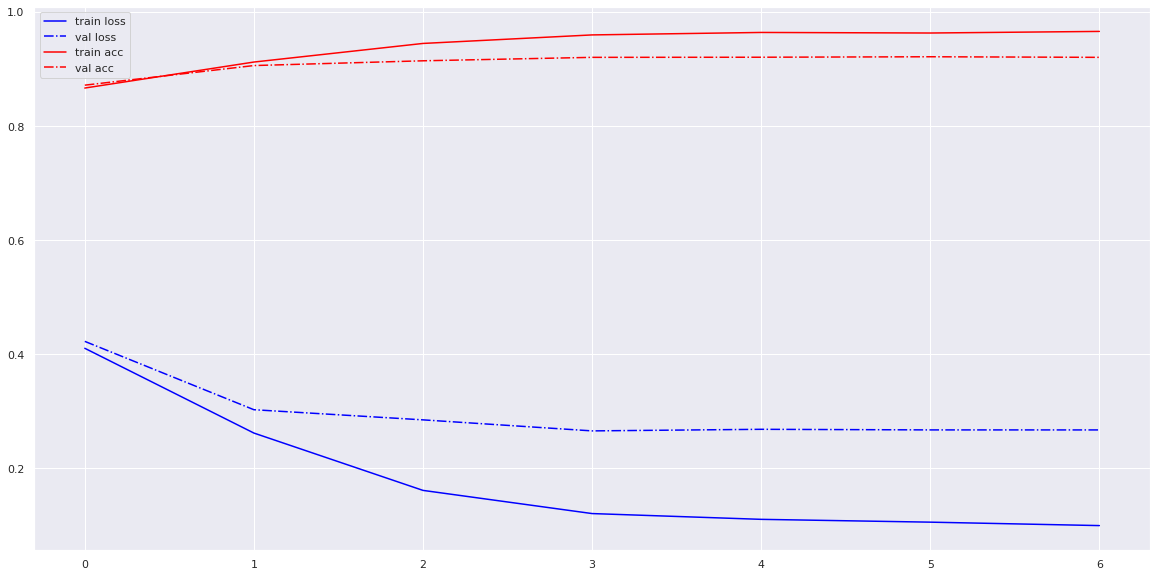

Best validation accuracy: 0.9214583039283752, epoch = 5
Best validation loss: 0.26567065715789795, epoch = 3


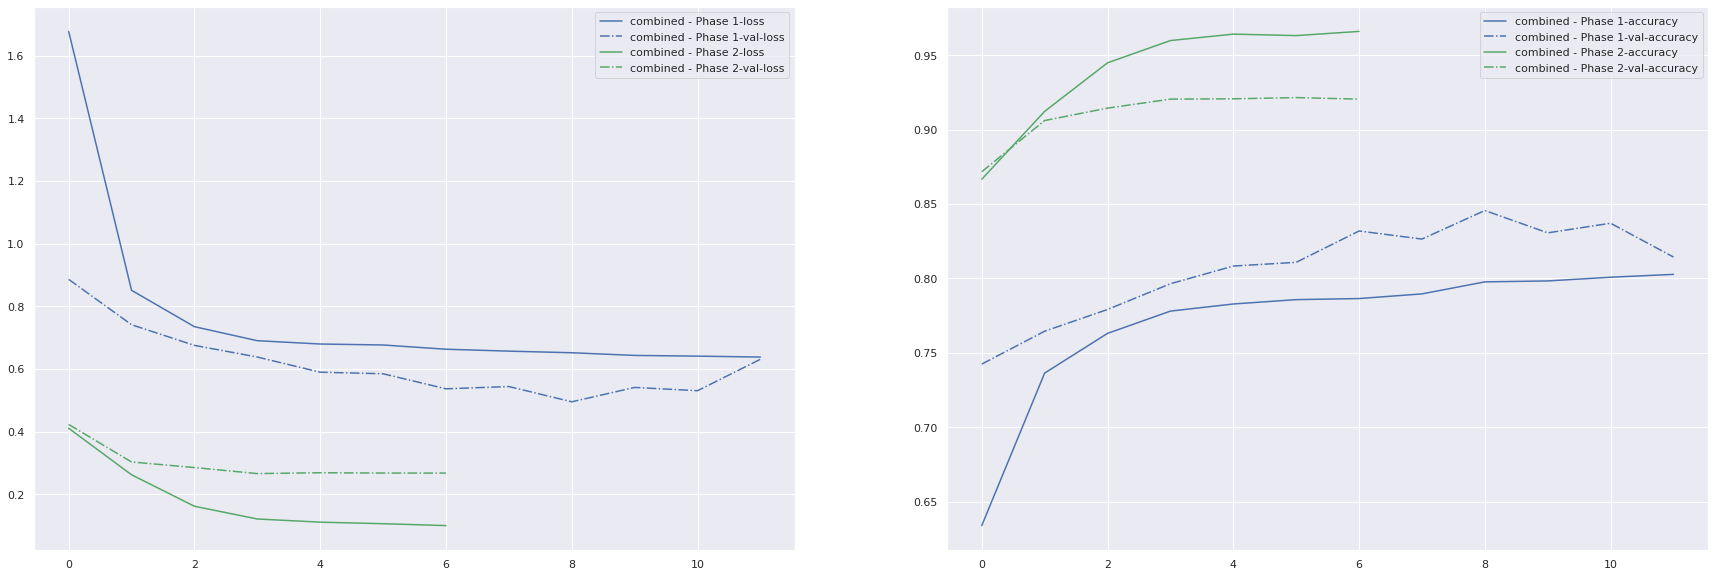

In [56]:
vgg16_ft = tf.keras.applications.VGG16(\
                                  include_top=False,\
                                  weights='imagenet',\
                                  input_shape=trainX[0].shape)
vgg16_ft.trainable = False

myModel = ThreeAdditionalLayers.build(vgg16_ft.output_shape, n_classes)

vgg16_combined_model, vgg16_combined_history = combine_and_train_finetune(vgg16_ft, myModel, trainX, trainY, valX, valY, 25, 'block4_conv2')
vgg16_acc.append(max(vgg16_combined_history.history['val_accuracy']))


In [ ]:
gc.collect()
gc.collect()
vgg19_ft = tf.keras.applications.VGG19(\
                                    include_top=False,\
                                    weights='imagenet',\
                                    input_shape=trainX[0].shape)
vgg19_ft.trainable = False
print(vgg19_ft.summary())

myModel = ThreeAdditionalLayers.build(vgg19_ft.output_shape, n_classes)

vgg19_combined_model, vgg19_combined_history = combine_and_train_finetune(vgg19_ft, myModel, trainX, trainY, valX, valY, 25, 'block4_pool')
vgg19_acc.append(max(vgg19_combined_history.history['val_accuracy']))
print_all_saved_accuracies()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

In [ ]:
gc.collect()
gc.collect()
densenet_ft = tf.keras.applications.DenseNet201(\
                                  include_top=False,\
                                  input_shape=trainX[0].shape)

densenet_ft.trainable = False
print(densenet_ft.summary())

myModel = ThreeAdditionalLayers.build(densenet_ft.output_shape, n_classes)

densenet_combined_model, densenet_combined_history = combine_and_train_finetune(densenet_ft, myModel, trainX, trainY, valX, valY, 26, 'conv5_block31_2_conv')
densenet_acc.append(max(densenet_combined_history.history['val_accuracy']))
print_all_saved_accuracies()

In [ ]:
gc.collect()
gc.collect()

resnet50_ft = tf.keras.applications.ResNet50V2(\
                                          include_top=False,\
                                          weights='imagenet',\
                                          input_shape=trainX[0].shape)

resnet50_ft.trainable = False
print(resnet50_ft.summary())

myModel = ThreeAdditionalLayers.build(resnet50_ft.output_shape, n_classes)

resnet50_combined_model, resnet50_combined_history = combine_and_train_finetune(resnet50_ft, myModel, trainX, trainY, valX, valY, 26, 'conv5_block3_1_conv')
resnet50_acc.append(max(resnet50_combined_history.history['val_accuracy']))
print_all_saved_accuracies()

In [ ]:
densenet_names.append('finetune2')
compare_pretrained_models()

In [ ]:
import IPython

n_classes = len(np.unique(np.concatenate((trainY, valY))))
class BaseModelFinetune:
    @staticmethod
    def build(inshape, nlabels):
        model = tf.keras.Sequential(name="BaseLineShallowNet")
        model.add(tf.keras.layers.Flatten())
        model.add(tf.keras.layers.Dense(nlabels, activation='softmax'))
        return model

In [ ]:
vgg16_ft = tf.keras.applications.VGG16(\
                                  include_top=False,\
                                  weights='imagenet',\
                                  input_shape=trainX[0].shape)
vgg16_ft.trainable = False

myModel = BaseModelFinetune.build(vgg16_ft.output_shape, n_classes)

vgg16_combined_model, vgg16_combined_history = combine_and_train_finetune(vgg16_ft, myModel, trainX, trainY, valX, valY, 25, 'block4_conv2')
vgg16_acc.append(max(vgg16_combined_history.history['val_accuracy']))


In [ ]:
gc.collect()
gc.collect()
vgg19_ft = tf.keras.applications.VGG19(\
                                    include_top=False,\
                                    weights='imagenet',\
                                    input_shape=trainX[0].shape)
vgg19_ft.trainable = False
print(vgg19_ft.summary())

myModel = BaseModelFinetune.build(vgg19_ft.output_shape, n_classes)

vgg19_combined_model, vgg19_combined_history = combine_and_train_finetune(vgg19_ft, myModel, trainX, trainY, valX, valY, 25, 'block4_pool')
vgg19_acc.append(max(vgg19_combined_history.history['val_accuracy']))
print_all_saved_accuracies()

In [ ]:
gc.collect()
gc.collect()
densenet_ft = tf.keras.applications.DenseNet201(\
                                  include_top=False,\
                                  input_shape=trainX[0].shape)

densenet_ft.trainable = False
print(densenet_ft.summary())

myModel = BaseModelFinetune.build(densenet_ft.output_shape, n_classes)

densenet_combined_model, densenet_combined_history = combine_and_train_finetune(densenet_ft, myModel, trainX, trainY, valX, valY, 26, 'conv5_block31_2_conv')
densenet_acc.append(max(densenet_combined_history.history['val_accuracy']))
print_all_saved_accuracies()

In [ ]:
gc.collect()
gc.collect()

resnet50_ft = tf.keras.applications.ResNet50V2(\
                                          include_top=False,\
                                          weights='imagenet',\
                                          input_shape=trainX[0].shape)

resnet50_ft.trainable = False
print(resnet50_ft.summary())

myModel = BaseModelFinetune.build(resnet50_ft.output_shape, n_classes)

resnet50_combined_model, resnet50_combined_history = combine_and_train_finetune(resnet50_ft, myModel, trainX, trainY, valX, valY, 26, 'conv5_block3_1_conv')
resnet50_acc.append(max(resnet50_combined_history.history['val_accuracy']))
print_all_saved_accuracies()

In [ ]:
densenet_names.append('finetune0')
compare_pretrained_models()